# Linear Regression in Python (transcription)

# Overview

Linear regression is a standard tool for analyzing the relationship between two or more variables In this lecture we’ll use the Python package statsmodels to estimate, interpret, and visualize linear regression models Along the way we’ll discuss a variety of topics, including 

* simple and multivariate linear regression
* visualization
* endogeneity and omitted variable bias
* two-stage least squares

As an example, we will replicate results from Acemoglu, Johnson and Robinson’s seminal paper [AJR01] In the paper, the authors emphasize the importance of institutions in economic development The main contribution is the use of settler mortality rates as a source of exogenous variation in institutional differences Such variation is needed to determine whether it is institutions that give rise to greater economic growth, rather than the other way around

# Simple Linear Regression

[AJR01] wish to determine whether or not differences in institutions can help to explain observed economic outcomes

How do we measure institutional differences and economic outcomes?

In this paper,

economic outcomes are proxied by log GDP per capita in 1995, adjusted for exchange rates
institutional differences are proxied by an index of protection against expropriation on average over 1985-95, constructed by the Political Risk Services Group
These variables and other data used in the paper are available for download on Daron Acemoglu’s webpage



# We will use pandas’ .read_stata() function to read in data contained in the .dta files to dataframes

In [18]:
import pandas as pd

df1 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable1.dta')
df1.head()

,shortnam,euro1900,excolony,avexpr,logpgp95,cons1,cons90,democ00a,cons00a,extmort4,logem4,loghjypl,baseco
0,AFG,0.000000,1.0,NaN,NaN,1.0,2.0,1.0,1.0,93.699997,4.540098,NaN,NaN
1,AGO,8.000000,1.0,5.363636,7.770645,3.0,3.0,0.0,1.0,280.000000,5.634789,-3.411248,1.0
2,ARE,0.000000,1.0,7.181818,9.804219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ARG,60.000004,1.0,6.386364,9.133459,1.0,6.0,3.0,3.0,68.900002,4.232656,-0.872274,1.0
4,ARM,0.000000,0.0,NaN,7.682482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Let’s use a scatterplot to see whether any obvious relationship exists between GDP per capita and the protection against expropriation index

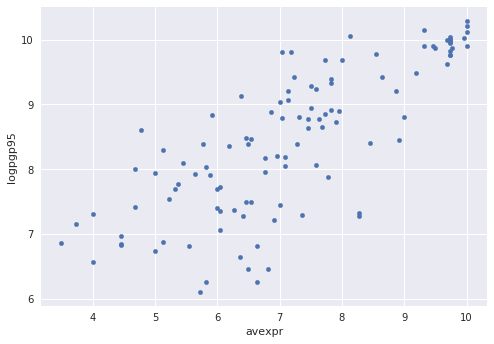

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

df1.plot(x='avexpr', y='logpgp95', kind='scatter')
plt.show()

The plot shows a fairly strong positive relationship between protection against expropriation and log GDP per capita

Specifically, if higher protection against expropriation is a measure of institutional quality, then better institutions appear to be positively correlated with better economic outcomes (higher GDP per capita)

Given the plot, choosing a linear model to describe this relationship seems like a reasonable assumption

We can write our model as

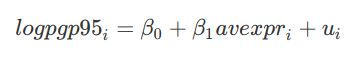

where:

* β0 is the intercept of the linear trend line on the y-axis
* β1 is the slope of the linear trend line, representing the marginal effect of protection against risk on log GDP per capita
* ui is a random error term (deviations of observations from the linear trend due to factors not included in the model)

# Visually, this linear model involves choosing a straight line that best fits the data, as in the following plot (Figure 2 in [AJR01])



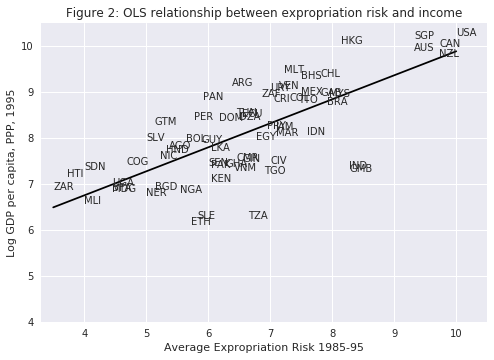

In [20]:
import numpy as np

# Dropping NA's is required to use numpy's polyfit
df1_subset = df1.dropna(subset=['logpgp95', 'avexpr'])

# Use only 'base sample' for plotting purposes
df1_subset = df1_subset[df1_subset['baseco'] == 1]

X = df1_subset['avexpr']
y = df1_subset['logpgp95']
labels = df1_subset['shortnam']

# Replace markers with country labels
plt.scatter(X, y, marker='')

for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
plt.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

plt.xlim([3.3,10.5])
plt.ylim([4,10.5])
plt.xlabel('Average Expropriation Risk 1985-95')
plt.ylabel('Log GDP per capita, PPP, 1995')
plt.title('Figure 2: OLS relationship between expropriation risk and income')
plt.show()

The most common technique to estimate the parameters (β‘s) of the linear model is Ordinary Least Squares (OLS)

As the name implies, an OLS model is solved by finding the parameters that minimize the sum of squared residuals, ie.

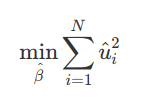

where u^i is the difference between the observation and the predicted value of the dependent variable

To estimate the constant term β0, we need to add a column of 1’s to our dataset (consider the equation if β0 was replaced with β0xi and xi=1)

In [21]:
df1['const'] = 1

Now we can construct our model in statsmodels using the OLS function

We will use pandas dataframes with statsmodels, however standard arrays can also be used as arguments

In [22]:
import statsmodels.api as sm

reg1 = sm.OLS(endog=df1['logpgp95'], exog=df1[['const', 'avexpr']], missing='drop')
type(reg1)


statsmodels.regression.linear_model.OLS

So far we have simply constructed our model

We need to use .fit() to obtain parameter estimates β^0 and β^1

In [23]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

We now have the fitted regression model stored in results

To view the OLS regression results, we can call the .summary() method

Note that an observation was mistakenly dropped from the results in the original paper (see the note located in maketable2.do from Acemoglu’s webpage), and thus the coefficients differ slightly

In [24]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     171.4
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           4.16e-24
Time:                        14:52:29   Log-Likelihood:                -119.71
No. Observations:                 111   AIC:                             243.4
Df Residuals:                     109   BIC:                             248.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6261      0.301     15.391      0.0

# From our results, we see that

* The intercept β^0=4.63
* The slope β^1=0.53
* The positive β^1 parameter estimate implies that institutional quality has a positive effect on economic outcomes, as we saw in the figure
* The p-value of 0.000 for β^1 implies that the effect of institutions on GDP is statistically significant (using p < 0.05 as a rejection rule)
* The R-squared value of 0.611 indicates that around 61% of variation in log GDP per capita is explained by protection against expropriation


Using our parameter estimates, we can now write our estimated relationship as

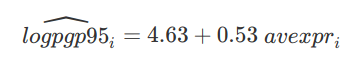

This equation describes the line that best fits our data, as shown in Figure 2

We can use this equation to predict the level of log GDP per capita for a value of the index of expropriation protection

For example, for a country with an index value of 7.07 (the average for the dataset), we find that their predicted level of log GDP per capita in 1995 is 8.38

In [25]:
mean_expr = np.mean(df1_subset['avexpr'])
mean_expr

6.515625

In [26]:
predicted_logpdp95 = 4.63 + 0.53 * 7.07
predicted_logpdp95

8.3771

An easier (and more accurate) way to obtain this result is to use .predict() and set constant=1 and avexpri=mean_expr

In [27]:
results.predict(exog=[1, mean_expr])

array([8.09156367])

We can obtain an array of predicted logpgp95i for every value of avexpri in our dataset by calling .predict() on our results

Plotting the predicted values against avexpri shows that the predicted values lie along the linear line that we fitted above

The observed values of logpgp95i are also plotted for comparison purposes

Text(0,0.5,'logpgp95')

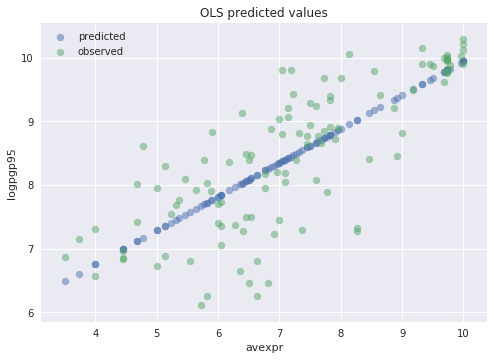

In [28]:
# Drop missing observations from whole sample

df1_plot = df1.dropna(subset=['logpgp95', 'avexpr'])

# Plot predicted values

plt.scatter(df1_plot['avexpr'], results.predict(), alpha=0.5, label='predicted')

# Plot observed values

plt.scatter(df1_plot['avexpr'], df1_plot['logpgp95'], alpha=0.5, label='observed')

plt.legend()
plt.title('OLS predicted values')
plt.xlabel('avexpr')
plt.ylabel('logpgp95')

# Extending the Linear Regression Model

So far we have only accounted for institutions affecting economic performance - almost certainly there are numerous other factors affecting GDP that are not included in our model

Leaving out variables that affect logpgp95i will result in omitted variable bias, yielding biased and inconsistent parameter estimates

We can extend our bivariate regression model to a multivariate regression model by adding in other factors that may affect logpgp95i
[AJR01] consider other factors such as:

* the effect of climate on economic outcomes; latitude is used to proxy this
* differences that affect both economic performance and institutions, eg. cultural, historical, etc.; controlled for with the use of continent dummies

Let’s estimate some of the extended models considered in the paper (Table 2) using data from maketable2.dta

In [32]:
df2 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable2.dta')

# Add constant term to dataset
df2['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'avexpr']
X2 = ['const', 'avexpr', 'lat_abst']
X3 = ['const', 'avexpr', 'lat_abst', 'asia', 'africa', 'other']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df2['logpgp95'], df2[X1], missing='drop').fit()
reg2 = sm.OLS(df2['logpgp95'], df2[X2], missing='drop').fit()
reg3 = sm.OLS(df2['logpgp95'], df2[X3], missing='drop').fit()

Now that we have fitted our model, we will use summary_col to display the results in a single table (model numbers correspond to those in the paper)

In [33]:
from statsmodels.iolib.summary2 import summary_col

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 3',
                                         'Model 4'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'avexpr',
                                             'lat_abst',
                                             'asia',
                                             'africa'])

results_table.add_title('Table 2 - OLS Regressions')

print(results_table)

SyntaxError: invalid syntax (<ipython-input-33-d5e383110d5c>, line 3)

# Endogeneity

As [AJR01] discuss, the OLS models likely suffer from endogeneity issues, resulting in biased and inconsistent model estimates

Namely, there is likely a two-way relationship between institutions and economic outcomes:

* richer countries may be able to afford or prefer better institutions
* variables that affect income may also be correlated with institutional differences
* the construction of the index may be biased; analysts may be biased towards seeing countries with higher income having better institutions

To deal with endogeneity, we can use two-stage least squares (2SLS) regression, which is an extension of OLS regression

This method requires replacing the endogenous variable avexpri with a variable that is:

1 correlated with avexpri

2 not correlated with the error term (ie. it should not directly affect the dependent variable, otherwise it would be correlated with ui due to omitted variable bias)

The new set of regressors is called an instrument, which aims to remove endogeneity in our proxy of institutional differences

The main contribution of [AJR01] is the use of settler mortality rates to instrument for institutional differences

They hypothesize that higher mortality rates of colonizers led to the establishment of institutions that were more extractive in nature (less protection against expropriation), and these institutions still persist today

Using a scatterplot (Figure 3 in [AJR01]), we can see protection against expropriation is negatively correlated with settler mortality rates, coinciding with the authors’ hypothesis and satisfying the first condition of a valid instrument

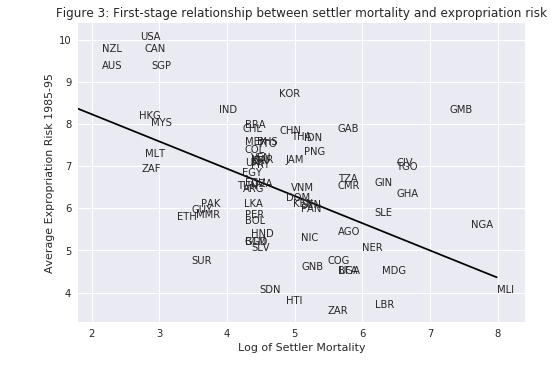

In [34]:
# Dropping NA's is required to use numpy's polyfit
df1_subset2 = df1.dropna(subset=['logem4', 'avexpr'])

X = df1_subset2['logem4']
y = df1_subset2['avexpr']
labels = df1_subset2['shortnam']

# Replace markers with country labels
plt.scatter(X, y, marker='')

for i, label in enumerate(labels):
    plt.annotate(label, (X.iloc[i], y.iloc[i]))

# Fit a linear trend line
plt.plot(np.unique(X),
         np.poly1d(np.polyfit(X, y, 1))(np.unique(X)),
         color='black')

plt.xlim([1.8,8.4])
plt.ylim([3.3,10.4])
plt.xlabel('Log of Settler Mortality')
plt.ylabel('Average Expropriation Risk 1985-95')
plt.title('Figure 3: First-stage relationship between settler mortality and expropriation risk')
plt.show()

The second condition may not be satisfied if settler mortality rates in the 17th to 19th centuries have a direct effect on current GDP (in addition to their indirect effect through institutions)

For example, settler mortality rates may be related to the current disease environment in a country, which could affect current economic performance

[AJR01] argue this is unlikely because:

* The majority of settler deaths were due to malaria and yellow fever, and had limited effect on local people
* The disease burden on local people in Africa or India, for example, did not appear to be higher than average, supported by relatively high population densities in these areas before colonization

As we appear to have a valid instrument, we can use 2SLS regression to obtain consistent and unbiased parameter estimates

# First stage

The first stage involves regressing the endogenous variable (avexpri) on the instrument

The instrument is the set of all exogenous variables in our model (and not just the variable we have replaced)

Using model 1 as an example, our instrument is simply a constant and settler mortality rates logem4i
Therefore, we will estimate the first-stage regression as

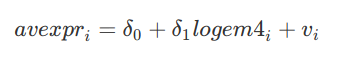

The data we need to estimate this equation is located in maketable4.dta (only complete data, indicated by baseco = 1, is used for estimation)

In [35]:
# Import and select the data
df4 = pd.read_stata('https://github.com/QuantEcon/QuantEcon.lectures.code/raw/master/ols/maketable4.dta')
df4 = df4[df4['baseco'] == 1]

# Add a constant variable
df4['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df4['avexpr'],
                    df4[['const', 'logem4']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                 avexpr   R-squared:                       0.270
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     22.95
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           1.08e-05
Time:                        14:59:39   Log-Likelihood:                -104.83
No. Observations:                  64   AIC:                             213.7
Df Residuals:                      62   BIC:                             218.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3414      0.611     15.296      0.0

# Second stage

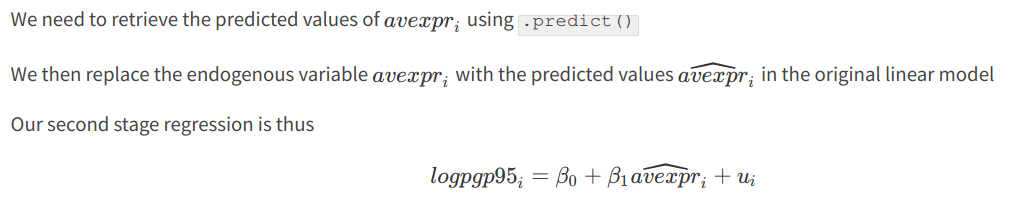

In [37]:
df4['predicted_avexpr'] = results_fs.predict()

results_ss = sm.OLS(df4['logpgp95'],
                    df4[['const', 'predicted_avexpr']]).fit()
print(results_ss.summary())

                            OLS Regression Results                            
Dep. Variable:               logpgp95   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     56.60
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           2.66e-10
Time:                        15:01:48   Log-Likelihood:                -72.268
No. Observations:                  64   AIC:                             148.5
Df Residuals:                      62   BIC:                             152.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9097      0.823  

The second-stage regression results give us an unbiased and consistent estimate of the effect of institutions on economic outcomes

The result suggests a stronger positive relationship than what the OLS results indicated

Note that while our parameter estimates are correct, our standard errors are not and for this reason, computing 2SLS ‘manually’ (in stages with OLS) is not recommended

We can correctly estimate a 2SLS regression in one step using the linearmodels package, an extension of statsmodels

To install this package, you will need to run pip install linearmodels in your command line

In [41]:
from linearmodels.iv import IV2SLS

SyntaxError: invalid syntax (model.py, line 137)

In [42]:
iv = IV2SLS(dependent=df4['logpgp95'],
            exog=df4['const'],
            endog=df4['avexpr'],
            instruments=df4['logem4']).fit(cov_type='unadjusted')

print(iv.summary)

NameError: name 'IV2SLS' is not defined

Given that we now have consistent and unbiased estimates, we can infer from the model we have estimated that institutional differences (stemming from institutions set up during colonization) can help to explain differences in income levels across countries today

[AJR01] use a marginal effect of 0.94 to calculate that the difference in the index between Chile and Nigeria (ie. institutional quality) implies up to a 7-fold difference in income, emphasizing the significance of institutions in economic development

# Summary

We have demonstrated basic OLS and 2SLS regression in statsmodels and linearmodels

If you are familiar with R, you may want use the formula interface to statsmodels, or consider using r2py to call R from within Python